In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

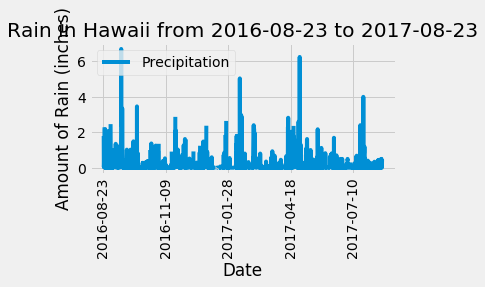

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = dt.date(int(max(session.query(Measurement.date).all())[0][:4]), 
                   int(max(session.query(Measurement.date).all())[0][5:7]), 
                   int(max(session.query(Measurement.date).all())[0][8:]))
last_year = last_day - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_dates = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= last_year.strftime('%Y-%m-%d')).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(rain_dates, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='Date', ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.title('Rain in Hawaii from 2016-08-23 to 2017-08-23')
plt.ylabel('Amount of Rain (inches)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.tight_layout()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').\
                group_by(Measurement.station).first()


('USC00519281', 54.0, 85.0, 71.66378066378067)

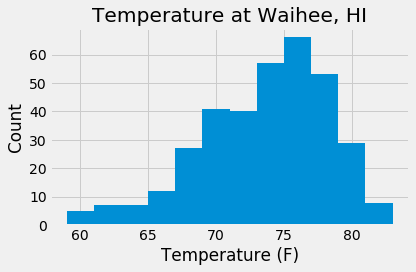

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins_list = 12

temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
                                    filter(Measurement.date >= last_year.strftime('%Y-%m-%d')).\
                                    order_by(Measurement.date).all()
temps = np.ravel(temps)

plt.hist(temps, bins=bins_list)

plt.title('Temperature at Waihee, HI')
plt.ylabel("Count")
plt.xlabel("Temperature (F)")
plt.tight_layout()


## Bonus Challenge Assignment

In [16]:
from scipy import stats
from scipy import mean

june = session.query(Measurement.tobs).filter(func.strftime('%m', Measurement.date) == '06').all()
june = [t[0] for t in june]

December = session.query(Measurement.tobs).filter(func.strftime('%m', Measurement.date) == '12').all()
December = [t[0] for t in December]

print("Mean temperature in June: " + str(mean(june)))
print("Mean temperature in December: " + str(mean(December)))
print("-"*9)
print(stats.ttest_ind(june, December))

Mean temperature in June: 74.94411764705882
Mean temperature in December: 71.04152933421226
---------
Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  # This is added back by InteractiveShellApp.init_path()


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-06-06', '2017-06-13')
trip_temps = [trip_temps[0][0], trip_temps[0][1], trip_temps[0][2]]
print(trip_temps)


[72.0, 77.1923076923077, 83.0]


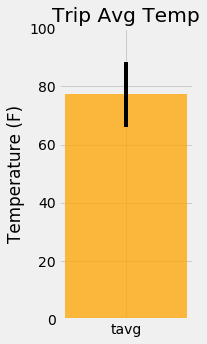

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,5))
plt.bar(height=trip_temps[1],x='tavg', width=0.1, yerr=(trip_temps[2]-trip_temps[0]), color='orange', alpha=0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.ylim(0,100)
plt.tight_layout()


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                filter(Measurement.date >= '2017-06-06').filter(Measurement.date <= '2017-06-13').\
                group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
                filter(Measurement.station == Station.station).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.17),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.8599999999999999),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1300000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.55),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.13999999999999999),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start = dt.date(2017,6,6)
end = dt.date(2017,6,13)

# Use the start and end date to create a range of dates
trip_dates1 = [(start + dt.timedelta(days=x)) for x in range((end-start).days+1)]

# Stip off the year and save a list of %m-%d strings
trip_dates2 = [d.strftime('%m-%d') for d in trip_dates1]

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in trip_dates2:
    normals.append(daily_normals(day)[0])

normals


[(70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Hawaii_daily_normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
Hawaii_daily_normals_df['date'] = trip_dates1
Hawaii_daily_normals_df.set_index('date', inplace=True)
Hawaii_daily_normals_df.head(8)


,tmin,tavg,tmax
date,,,
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0
2017-06-12,66.0,75.666667,83.0
2017-06-13,68.0,75.666667,81.0


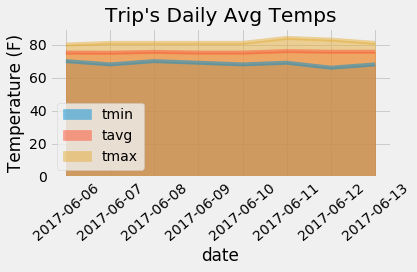

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
Hawaii_daily_normals_df.plot.area(stacked=False)
plt.title("Trip's Daily Avg Temps")
plt.ylabel("Temperature (F)")
plt.ylim(0,90)
plt.xticks(rotation=40)
plt.tight_layout()
